Reference :
https://towardsdatascience.com/basic-time-series-analysis-and-trading-strategy-with-bitcoin-price-data-1a8f1a30f11

In [1]:
# !pip install yfinance

In [2]:
import pandas as pd
# import pandas_datareader.data as web
# from pandas_datareader import data
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
## plt.style.use('fivethirtyeight')
## %config InlineBackend.figure_format = 'retina'
## %matplotlib inline

In [3]:
btc = yf.download('BTC-USD', start='2017-1-1', end='2017-12-31')


[*********************100%***********************]  1 of 1 completed


In [4]:
np.sum(btc['Close'] - btc['Adj Close'])

0.0

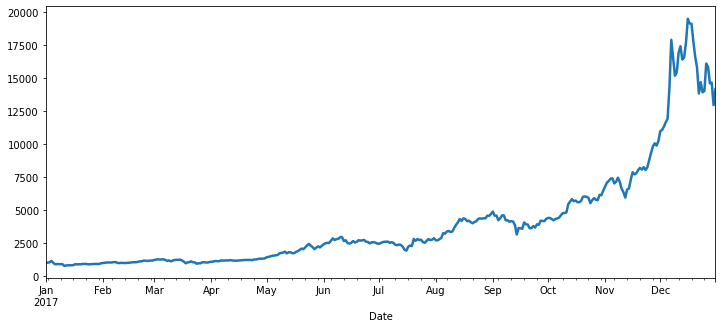

In [5]:
btc_adj = btc['Adj Close']
btc_adj.plot(lw=2.5, figsize=(12, 5))
plt.show()

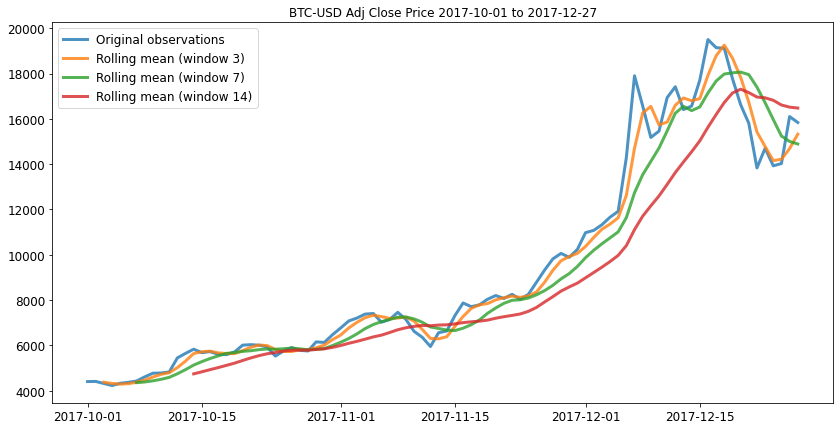

In [6]:
btc_recent = btc_adj.loc['2017-10-01':'2017-12-27']
rroll_d3 = btc_recent.rolling(window=3).mean()
rroll_d7 = btc_recent.rolling(window=7).mean()
rroll_d14 = btc_recent.rolling(window=14).mean()
plt.figure(figsize=(14, 7))
plt.plot(btc_recent.index, btc_recent, lw=3, alpha=0.8,label='Original observations')
plt.plot(btc_recent.index, rroll_d3, lw=3, alpha=0.8,label='Rolling mean (window 3)')
plt.plot(btc_recent.index, rroll_d7, lw=3, alpha=0.8,label='Rolling mean (window 7)')
plt.plot(btc_recent.index, rroll_d14, lw=3, alpha=0.8,label='Rolling mean (window 14)')
plt.title('BTC-USD Adj Close Price 2017-10-01 to 2017-12-27')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [7]:
short_window = 10
mid_window = 50
signals = pd.DataFrame(index=btc_adj.index)
signals['signal'] = 0.0
roll_d10 = btc_adj.rolling(window=short_window).mean()
roll_d50 = btc_adj.rolling(window=mid_window).mean()
signals['short_mavg'] = roll_d10
signals['mid_mavg'] = roll_d50
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['mid_mavg'][short_window:], 1.0, 0.0)
signals['positions'] = signals['signal'].diff()

In [8]:
signals.loc[signals.positions == 1.0].index

DatetimeIndex(['2017-02-19', '2017-04-09', '2017-07-26', '2017-10-04'], dtype='datetime64[ns]', name='Date', freq=None)

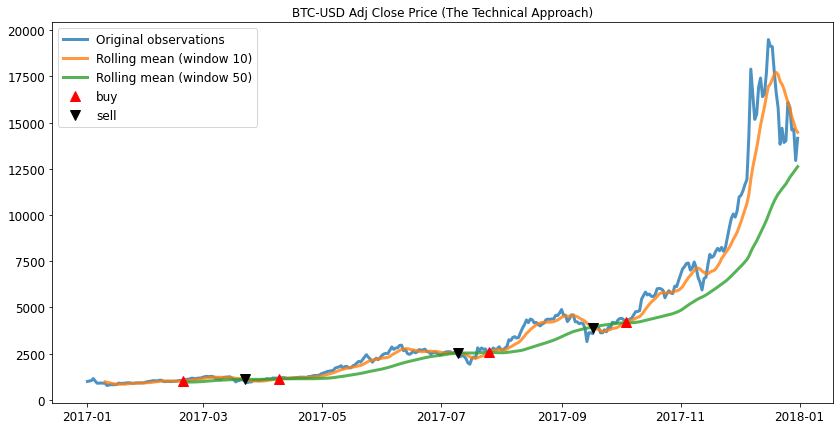

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(btc_adj.index, btc_adj, lw=3, alpha=0.8,label='Original observations')
plt.plot(btc_adj.index, roll_d10, lw=3, alpha=0.8,label='Rolling mean (window 10)')
plt.plot(btc_adj.index, roll_d50, lw=3, alpha=0.8,label='Rolling mean (window 50)')
plt.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='r', label='buy')
         
plt.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k', label='sell')
plt.title('BTC-USD Adj Close Price (The Technical Approach)')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [10]:
initial_investment = btc_adj.loc[list(signals[signals.positions == 1.0].index)][0]
bought = np.sum(btc_adj.loc[list(signals[signals.positions == 1.0].index)]*-1.0)
sold = np.sum(btc_adj.loc[list(signals[signals.positions == -1.0].index)])
current_btc_value = btc_adj[-1]
balance = pd.DataFrame([btc_adj.loc[list(signals[signals.positions == 1.0].index)]*-1.0,
              btc_adj.loc[list(signals[signals.positions == -1.0].index)]]).transpose()
balance = balance.fillna(0)
balance['balance'] = balance.sum(axis=1)
print ("Initial investment amount: {0:.2f} USD".format(initial_investment))
print ("Maximum invested amount: {0:.2f} USD".format(abs(min(balance.cumsum().balance))))
print ("Current asset value: {0:.2f} USD".format(bought+sold+current_btc_value))

Initial investment amount: 1047.87 USD
Maximum invested amount: 2000.52 USD
Current asset value: 12155.88 USD


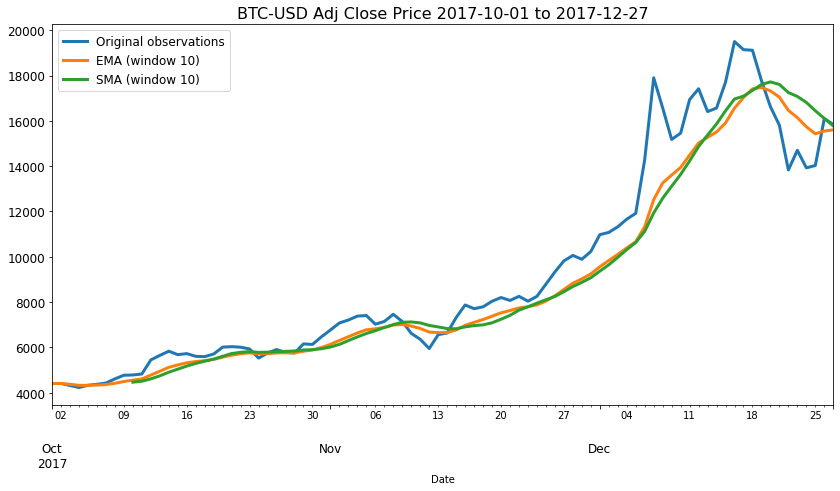

In [11]:
exp_weighted_mean = btc_recent.resample('D').sum().ewm(span=10).mean()
sma_d10 = btc_recent.rolling(window=10).mean()
ax = btc_recent.plot(lw=3, figsize=(14, 7), label='Original observations')
exp_weighted_mean.plot(ax=ax, lw=3, label='EMA (window 10)')
sma_d10.plot(ax=ax, lw=3, label='SMA (window 10)')
plt.title('BTC-USD Adj Close Price 2017-10-01 to 2017-12-27', fontsize=16)
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [12]:
exp_weighted_mean = btc_recent.resample('D').sum().ewm(span=20).mean()
signals_ema = pd.DataFrame(index=btc_recent.index)
signals_ema['signal'] = 0.0
signals_ema['original'] = btc_recent
signals_ema['EMA'] = exp_weighted_mean
signals_ema['signal'] = np.where(signals_ema['original'] > signals_ema['EMA'], 1.0, 0.0)
signals_ema['positions'] = signals_ema['signal'].diff()

In [13]:
signals_ema.loc[signals_ema.positions == 1.0].index

DatetimeIndex(['2017-10-02', '2017-10-06', '2017-10-25', '2017-11-13',
               '2017-12-26'],
              dtype='datetime64[ns]', name='Date', freq=None)

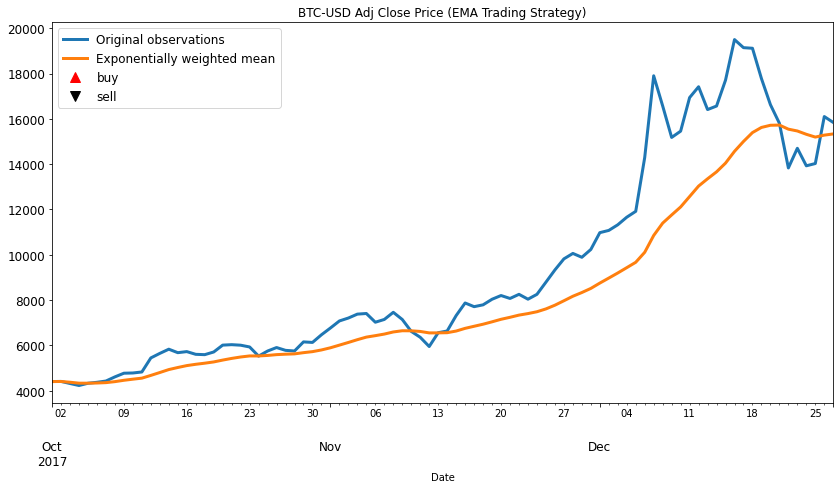

In [14]:
plt.figure(figsize=(14, 7))
ax = btc_recent.plot(lw=3, figsize=(14, 7), label='Original observations')
exp_weighted_mean.plot(ax=ax, lw=3, label='Exponentially weighted mean')
plt.plot(signals_ema.loc[signals_ema.positions == 1.0].index, 
         signals_ema.EMA[signals_ema.positions == 1.0],
         '^', markersize=10, color='r', label='buy')
         
plt.plot(signals_ema.loc[signals_ema.positions == -1.0].index, 
         signals_ema.EMA[signals_ema.positions == -1.0],
         'v', markersize=10, color='k', label='sell')
plt.title('BTC-USD Adj Close Price (EMA Trading Strategy)')

plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()